# Import Libraries

In [1]:
# Tools
import os
import pandas as pd
import numpy as np
from tqdm import trange
from collections import defaultdict

# Audio file processing
import librosa
import librosa.display

# Visual
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Dataset Description

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) - [Link](https://zenodo.org/record/1188976#.XTod4S2ZO3U)
  * The RAVDESS contains 7356 files. Each file was rated 10 times on emotional validity, intensity, and genuineness. Ratings were provided by 247 individuals who were characteristic of untrained adult research participants from North America. A further set of 72 participants provided test-retest data. High levels of emotional validity, interrater reliability, and test-retest intrarater reliability were reported. 
  * Filename identifiers 

    * Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    * Vocal channel (01 = speech, 02 = song).
    * Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    * Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    * Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    * Repetition (01 = 1st repetition, 02 = 2nd repetition).
    * Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

#### Citation

"[The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)](https://zenodo.org/record/1188976)" by Livingstone & Russo is licensed under [CC BY-NA-SC 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).

# Load Data

In [2]:
# Load audio file names
data_folder_list = os.listdir('data/')
data_folder_list.remove('.DS_Store')
data = []
for folder in data_folder_list:
    files = os.listdir('data/'+folder)
    for file in files:
        data.append('data/'+folder+'/'+file)

# Create pandas dataframe for all files
emotion_mapping = {1:'neutral',2:'calm',3:'happy',4:'sad',5:'angry',6:'fearful',7:'disgust',8:'surprised'}
gender_mapping = {0:'female',1:'male'}
df = pd.DataFrame({
                   'filename':data,
                   'emotion':[int(x.split('-')[2]) for x in data],
                   'emotion_desc':[emotion_mapping[int(x.split('-')[2])] for x in data],
                   'gender' :[gender_mapping[int(x.split('-')[0][-5:-3])%2] for x in data]
                  
                  })

# Generate Features - Automatic Using librosa.feature

In [16]:
# Function to 
def create_feature_df(sound_list,num_features):
    
    #
    sound_wave,sampling_rate = librosa.load(sound_list[0],sr=None,duration=2.5,offset=0.5)
    features = np.mean(librosa.feature.mfcc(y=sound_wave, sr=sampling_rate, n_mfcc=num_features),axis=1)
    num_features_created = len(features)
    
    # Create n number of empty lists to append features to
    empty_lists = [[] for x in range(num_features_created)]

    # Generate features and append to empty lists in empty_lists
    for i in trange(len(sound_list)):
        sound_wave,sampling_rate = librosa.load(sound_list[i],sr=sampling_rate,duration=2.5,offset=0.5,res_type='kaiser_fast')
        features = np.mean(librosa.feature.mfcc(y=sound_wave, sr=sampling_rate, n_mfcc=num_features),axis=1)
        for ix,feature in enumerate(features):
            empty_lists[ix].append(feature)
            
    # Remove feature that doesn't have full number of values
    empty_lists = [x for x in empty_lists if len(x)==len(sound_list)]
            
    # Create dictionary using feature list and return pandas dataframe
    df = defaultdict()
    for ix,feature in enumerate(empty_lists):
        df['feature_'+str(ix)]=feature 
 
    return pd.DataFrame(df)

# Create Pandas Dataframe with Data & Features

In [17]:
# Specify how many features to create using librosa's automatic feature generation function
num_features = 20

# Merge df with df_feature
df_features=create_feature_df(df['filename'],num_features)
df_merged = pd.concat([df, df_features], axis=1)
df_merged.head()

100%|██████████| 1440/1440 [00:10<00:00, 131.49it/s]


,filename,emotion,emotion_desc,gender,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,data/Actor_16/03-01-05-01-02-01-16.wav,5,angry,female,-480.580078,76.326584,-10.627720,15.457519,-9.453357,-1.259657,...,-14.116349,-2.188636,-6.942791,-10.229346,-6.281795,-3.178989,-9.930803,-5.104645,-10.610657,-4.183223
1,data/Actor_16/03-01-06-01-02-02-16.wav,6,fearful,female,-526.317505,74.890358,-8.940951,10.727108,-3.080891,6.100757,...,-7.729759,-0.013999,-10.435387,-15.115587,-3.938485,0.508711,-10.226834,-6.949420,-5.638691,-6.786476
2,data/Actor_16/03-01-06-02-01-02-16.wav,6,fearful,female,-359.621948,57.552151,-35.878036,-4.451132,-9.203217,-4.134377,...,-11.323414,-3.062282,-13.263997,-12.300721,3.166339,8.591240,-2.428875,6.111026,5.618315,6.217078
3,data/Actor_16/03-01-05-02-01-01-16.wav,5,angry,female,-392.883759,75.752419,-14.608527,8.182800,-5.470392,-4.709466,...,-9.968284,1.344865,-8.190225,-11.047806,-1.242552,-2.363670,-10.107604,-3.423309,-9.756444,-7.452469
4,data/Actor_16/03-01-07-01-01-01-16.wav,7,disgust,female,-578.037415,89.700165,0.860600,16.117153,-2.783844,3.387742,...,-9.880963,0.673469,-4.636721,-9.033373,-3.391528,1.257773,-7.673393,-4.996210,-4.577317,-2.976890


# EDA

#### Target Distribution

It's pretty evenly distributed between 8 emotions


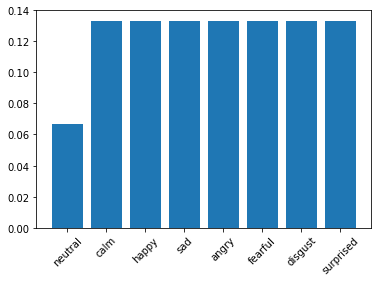

In [79]:
# From 'feature_engineering_instacart' notebook
target_pcts = df_merged['emotion'].value_counts(normalize=True) 
plt.bar(list(emotion_mapping.values()),target_pcts.sort_index())
plt.xticks(rotation=45)
print("It's pretty evenly distributed between 8 emotions")

/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


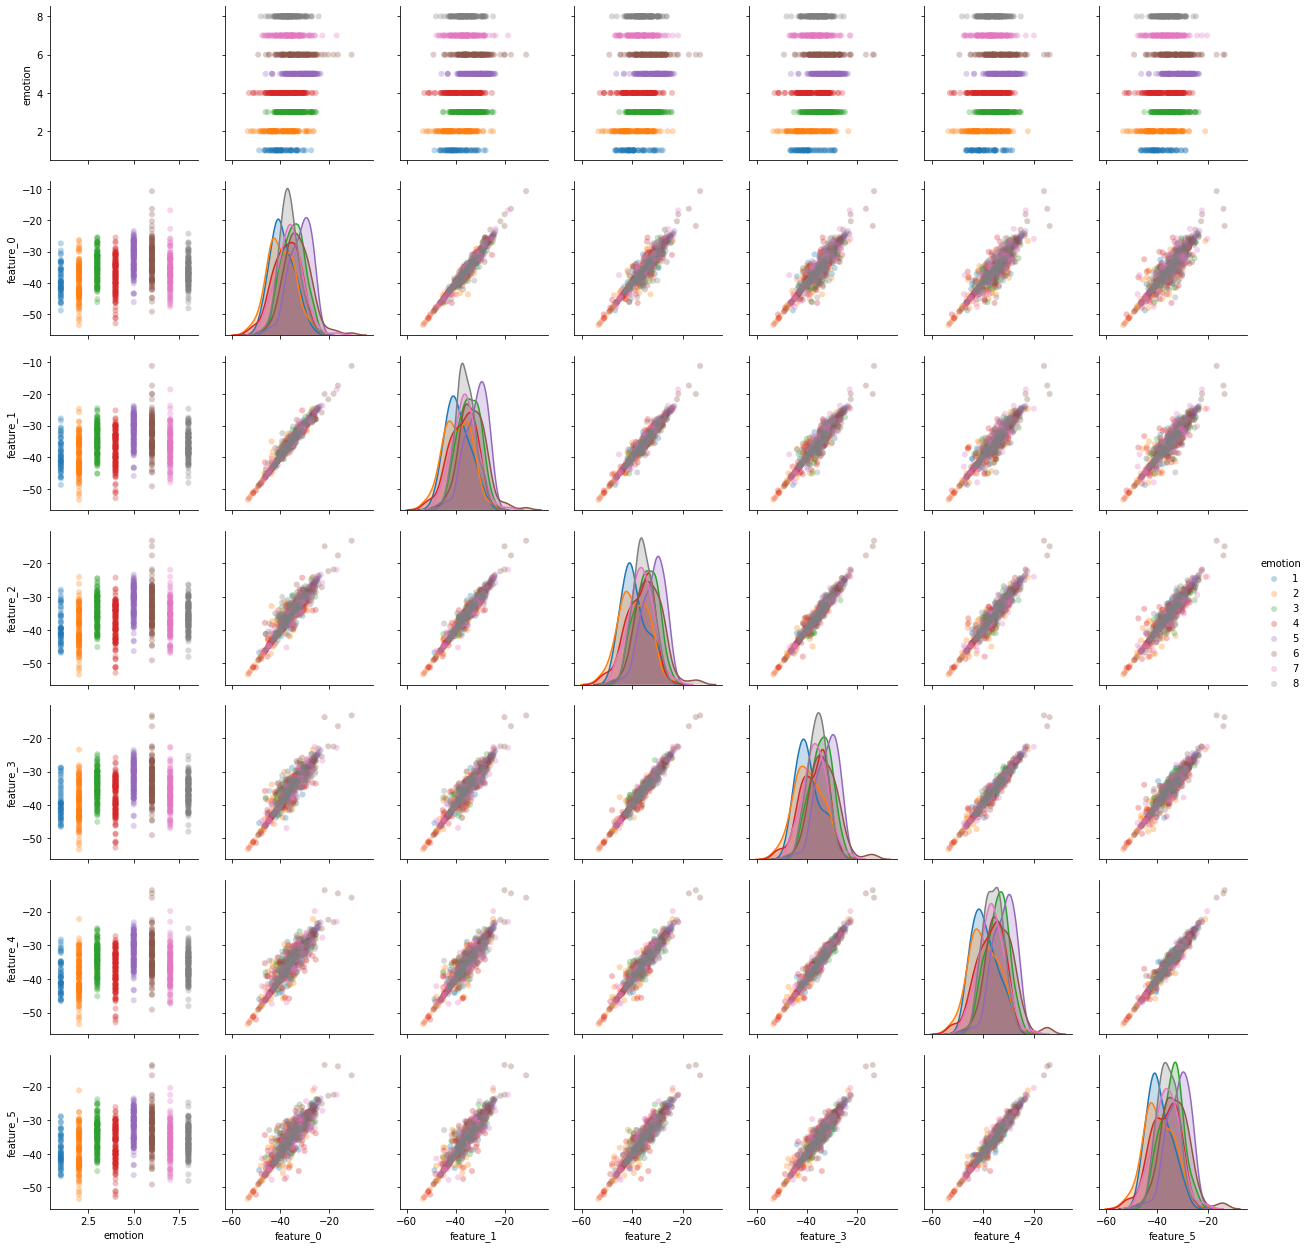

In [88]:
# From 'feature_engineering_instacart' notebook
def plot_features(df, sample_size=500):
    feature_columns = list(df.columns)[1:10]
    sample = df[feature_columns].sample(1000, random_state=44) 
    sns.pairplot(sample,hue='emotion', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df_merged)

#### Visualize a signal

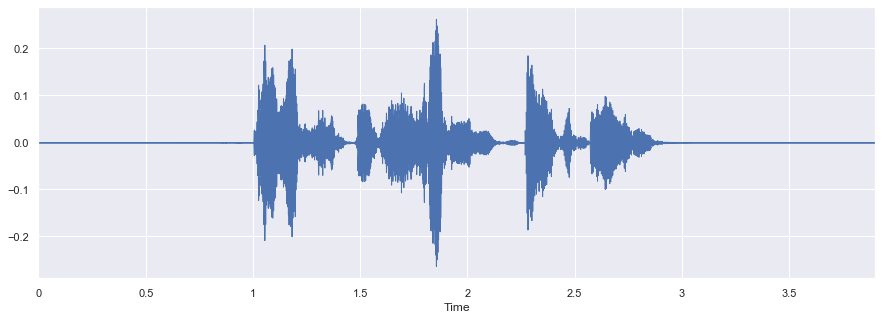

In [185]:
plt.figure(figsize=(15, 5))                    
sound_wave,sampling_rate = librosa.load(df['filename'][0],sr=None)
librosa.display.waveplot(sound_wave,sr=sampling_rate)

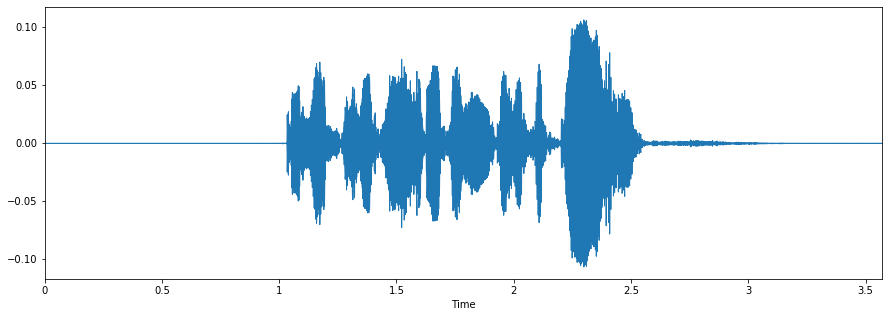

In [37]:
plt.figure(figsize=(15, 5))                    
sound_wave,sampling_rate = librosa.load(df['filename'][1],sr=None)
librosa.display.waveplot(sound_wave,sr=sampling_rate)

# Modeling

#### Train, Validation, Test Split

In [19]:
def custom_train_test_split(df,test_size):
    feature_columns = list(df.columns)[4:] 
    for ix,emotion in enumerate(df['emotion'].unique()):
        df_temp = df[df['emotion']==emotion]
        if ix==0:
            X_train, X_test, y_train, y_test = train_test_split(df_temp[feature_columns], df_temp['emotion'], test_size=test_size, random_state=209)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(df_temp[feature_columns], df_temp['emotion'], test_size=test_size, random_state=209)
            X_train = pd.concat([X_train,X_train_split])
            X_test = pd.concat([X_test,X_test_split])
            y_train = pd.concat([y_train,y_train_split])
            y_test = pd.concat([y_test,y_test_split])
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(df_merged,0.2)


### Baseline Model

#### Standardization of features

In [20]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)

#### Train Logistic Regression model

In [21]:
lr = LogisticRegression(random_state=209, solver='lbfgs',
                          multi_class='multinomial').fit(X_tr, y_train)

#### View Scores

In [22]:
def various_scores(model,X,y,data_type):
    pred = model.predict(X)
    print(data_type," Data")
    print('######################################################')
    print("Accuracy : {:.2f} %".format(metrics.accuracy_score(y, pred)*100))
    print('______________________________________________________')
    print(metrics.classification_report(pred,y,digits=2,target_names=list(emotion_mapping.values())))
    print('______________________________________________________')
    
    

In [23]:
various_scores(lr,X_tr,y_train,'Train')

Train  Data
######################################################
Accuracy : 50.57 %
______________________________________________________
              precision    recall  f1-score   support

     neutral       0.33      0.42      0.37        60
        calm       0.69      0.54      0.61       197
       happy       0.48      0.50      0.49       148
         sad       0.43      0.42      0.43       157
       angry       0.68      0.64      0.66       162
     fearful       0.45      0.45      0.45       152
     disgust       0.48      0.54      0.51       134
   surprised       0.41      0.46      0.43       137

    accuracy                           0.51      1147
   macro avg       0.49      0.50      0.49      1147
weighted avg       0.52      0.51      0.51      1147

______________________________________________________


In [24]:
various_scores(lr,X_te,y_test,'Test')

Test  Data
######################################################
Accuracy : 50.85 %
______________________________________________________
              precision    recall  f1-score   support

     neutral       0.15      0.43      0.22         7
        calm       0.69      0.50      0.58        54
       happy       0.44      0.52      0.47        33
         sad       0.46      0.38      0.41        48
       angry       0.72      0.72      0.72        39
     fearful       0.54      0.42      0.47        50
     disgust       0.38      0.58      0.46        26
   surprised       0.51      0.56      0.53        36

    accuracy                           0.51       293
   macro avg       0.49      0.51      0.48       293
weighted avg       0.54      0.51      0.52       293

______________________________________________________


### RandomizedSearchCV

#### Train & Test Split for RandomizedSearchCV

In [25]:
# Define cross-validation pipelines logistic regression model
lr_pipeline = Pipeline([
                        ('polynomial',PolynomialFeatures()),
                        ('standard',StandardScaler()),                        
                        ('model',LogisticRegression())
                        ])

# # print parameters for lasso & ridge cross-validation pipelines
print('Logistic Regression Model Params :\n\n',lr_pipeline.get_params().keys(),'\n')

Logistic Regression Model Params :

 dict_keys(['memory', 'steps', 'verbose', 'polynomial', 'standard', 'model', 'polynomial__degree', 'polynomial__include_bias', 'polynomial__interaction_only', 'polynomial__order', 'standard__copy', 'standard__with_mean', 'standard__with_std', 'model__C', 'model__class_weight', 'model__dual', 'model__fit_intercept', 'model__intercept_scaling', 'model__l1_ratio', 'model__max_iter', 'model__multi_class', 'model__n_jobs', 'model__penalty', 'model__random_state', 'model__solver', 'model__tol', 'model__verbose', 'model__warm_start']) 



In [38]:
df_merged

,filename,emotion,emotion_desc,gender,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,data/Actor_16/03-01-05-01-02-01-16.wav,5,angry,female,-480.580078,76.326584,-10.627720,15.457519,-9.453357,-1.259657,...,-14.116349,-2.188636,-6.942791,-10.229346,-6.281795,-3.178989,-9.930803,-5.104645,-10.610657,-4.183223
1,data/Actor_16/03-01-06-01-02-02-16.wav,6,fearful,female,-526.317505,74.890358,-8.940951,10.727108,-3.080891,6.100757,...,-7.729759,-0.013999,-10.435387,-15.115587,-3.938485,0.508711,-10.226834,-6.949420,-5.638691,-6.786476
2,data/Actor_16/03-01-06-02-01-02-16.wav,6,fearful,female,-359.621948,57.552151,-35.878036,-4.451132,-9.203217,-4.134377,...,-11.323414,-3.062282,-13.263997,-12.300721,3.166339,8.591240,-2.428875,6.111026,5.618315,6.217078
3,data/Actor_16/03-01-05-02-01-01-16.wav,5,angry,female,-392.883759,75.752419,-14.608527,8.182800,-5.470392,-4.709466,...,-9.968284,1.344865,-8.190225,-11.047806,-1.242552,-2.363670,-10.107604,-3.423309,-9.756444,-7.452469
4,data/Actor_16/03-01-07-01-01-01-16.wav,7,disgust,female,-578.037415,89.700165,0.860600,16.117153,-2.783844,3.387742,...,-9.880963,0.673469,-4.636721,-9.033373,-3.391528,1.257773,-7.673393,-4.996210,-4.577317,-2.976890
5,data/Actor_16/03-01-04-01-01-02-16.wav,4,sad,female,-644.607849,98.568008,6.923995,13.543920,4.251982,2.433018,...,-5.462162,-2.327852,-8.794063,-9.809936,-1.350420,-1.563623,-7.683310,-3.337888,-3.670259,-7.914393
6,data/Actor_16/03-01-04-02-02-02-16.wav,4,sad,female,-570.750977,88.291946,-9.823258,9.737024,-4.441309,7.738516,...,-6.995904,-3.837410,-12.275636,-11.700903,-4.076525,-0.551383,-10.957047,-3.185743,-7.017912,-7.621302
7,data/Actor_16/03-01-07-02-02-01-16.wav,7,disgust,female,-522.208313,73.190048,-0.164756,27.195015,-4.693729,9.003244,...,-10.953942,1.688761,-10.828823,-14.292724,-1.708963,-3.686225,-10.338302,-6.324974,-7.912479,-3.225763
8,data/Actor_16/03-01-08-02-02-01-16.wav,8,surprised,female,-474.271851,74.674881,-11.729820,1.078494,-7.822320,1.629428,...,-11.423016,-2.380746,-12.706484,-7.417462,-3.086897,-3.849255,-8.448290,-3.336217,-8.511429,-4.618779
9,data/Actor_16/03-01-08-01-01-01-16.wav,8,surprised,female,-583.628113,85.412140,-6.911815,3.807441,-0.868675,-0.223032,...,-3.687984,-2.156912,-10.375398,-6.608909,-3.027025,-6.506423,-5.307192,-2.692143,-9.386730,-7.251480


In [33]:
#Define hyperparameters for GridSearchCV & RandomizedSearchCV
C_vec = np.linspace(0,1000,100)
scoring_list = ['accuracy', 'balanced_accuracy','f1_micro','f1_macro','f1_weighted']
hyperparameters = {'polynomial__degree':[1,2],
                   'model__solver':['newton-cg', 'sag', 'saga' , 'lbfgs'],
                   'model__C':C_vec,
                   #'model__class_weight':['balanced',None],
                   'model__random_state':[209],
                   'model__multi_class':['multinomial']
                   }
lr_grid = RandomizedSearchCV(lr_pipeline,
                             param_distributions=hyperparameters,
                             cv=5,
                             random_state=209,
                             scoring=scoring_list[4],
                             n_iter=30,
                             verbose=0)
lr_grid.fit(X_train,y_train);

/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic

/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/sit

In [34]:
lr_grid.best_params_

{'polynomial__degree': 2,
 'model__solver': 'sag',
 'model__random_state': 209,
 'model__multi_class': 'multinomial',
 'model__C': 262.6262626262626}

In [35]:
various_scores(lr_grid,X_train,y_train,'Train')

Train  Data
######################################################
Accuracy : 76.20 %
______________________________________________________
              precision    recall  f1-score   support

     neutral       0.63      0.76      0.69        63
        calm       0.88      0.80      0.84       168
       happy       0.73      0.75      0.74       150
         sad       0.69      0.68      0.68       155
       angry       0.85      0.84      0.84       155
     fearful       0.76      0.78      0.77       150
     disgust       0.76      0.77      0.77       150
   surprised       0.73      0.71      0.72       156

    accuracy                           0.76      1147
   macro avg       0.75      0.76      0.76      1147
weighted avg       0.77      0.76      0.76      1147

______________________________________________________


In [36]:
various_scores(lr_grid,X_test,y_test,'Test')

Test  Data
######################################################
Accuracy : 62.46 %
______________________________________________________
              precision    recall  f1-score   support

     neutral       0.25      0.36      0.29        14
        calm       0.67      0.65      0.66        40
       happy       0.59      0.74      0.66        31
         sad       0.69      0.53      0.60        51
       angry       0.77      0.81      0.79        37
     fearful       0.74      0.64      0.69        45
     disgust       0.44      0.52      0.47        33
   surprised       0.67      0.62      0.64        42

    accuracy                           0.62       293
   macro avg       0.60      0.61      0.60       293
weighted avg       0.64      0.62      0.63       293

______________________________________________________
